 # Продемонстрируем примеры анализа данных из базы

### Подготовка

In [177]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pg_client import PgClient

In [80]:
def ten_best_coaches():
    client = PgClient()
    client.connect()
    coaches = []
    with client.connection.cursor() as cursor:
        cursor.execute(
            """
                SELECT name, experience  FROM basketball.coaches
                ORDER BY experience DESC
                LIMIT 10;
            """)
        coaches = cursor.fetchall()

    client.disconnect()
    return coaches

In [88]:
def this_week_games():
    client = PgClient()
    client.connect()

    games = []
    with client.connection.cursor() as cursor:
        cursor.execute(
            """
                SELECT * FROM basketball.schedule
                WHERE date BETWEEN NOW() AND NOW()::date + 14;
            """)
        games = cursor.fetchall()

    client.disconnect()
    return games

In [6]:
def teams_spendings():
    client = PgClient()
    client.connect()

    table = []
    with client.connection.cursor() as cursor:
        cursor.execute(
            """
                SELECT team_code,
                    SUM(cost) AS total_cost
                FROM (
                    SELECT team_code, cost
                    FROM basketball.coaches_contracts
                    WHERE NOW() BETWEEN valid_from AND valid_to
                
                    UNION ALL
                
                    SELECT team_code, cost
                    FROM basketball.players_contracts
                    WHERE NOW() BETWEEN valid_from AND valid_to
                ) AS combined_contracts
                GROUP BY team_code;
            """)
        table = cursor.fetchall()

    client.disconnect()
    return table

In [7]:
def la_stadium_schedule():
    client = PgClient()
    client.connect()
    
    table = []
    with client.connection.cursor() as cursor:
        cursor.execute(
            """
                SELECT date, home_team_code, guest_team_code FROM (
                    SELECT date, home_team_code, guest_team_code FROM basketball.schedule
                    WHERE guest_team_code IN (
                        SELECT team_code FROM basketball.stadiums
                        WHERE city = 'Los Angeles')
                
                    UNION ALL
                
                    SELECT date, home_team_code, guest_team_code FROM basketball.schedule
                    WHERE home_team_code IN (
                        SELECT team_code FROM basketball.stadiums
                        WHERE city = 'Los Angeles')
                ) as date_for_stadium_in_la
                ORDER BY date;
            """)
        table = cursor.fetchall()
        

    client.disconnect()
    return table

In [8]:
def teams_and_won_matches():
    client = PgClient()
    client.connect()

    table = []
    with client.connection.cursor() as cursor:
        cursor.execute(
            """
                SELECT name, wins FROM (SELECT t.team_code,
                       SUM((r.home_team_points > r.guest_team_points)::int) +
                       SUM((r.guest_team_points > r.home_team_points)::int) AS wins
                FROM basketball.teams t
                LEFT JOIN (
                    SELECT s.home_team_code AS team_code,
                           home_team_points,
                           guest_team_points
                    FROM basketball.game_results r
                    JOIN basketball.schedule s ON r.game_id = s.game_id
                
                    UNION ALL
                
                    SELECT s.guest_team_code AS team_code,
                           guest_team_points,
                           home_team_points
                    FROM basketball.game_results r
                    JOIN basketball.schedule s ON r.game_id = s.game_id
                ) AS r ON t.team_code = r.team_code
                GROUP BY t.team_code) AS team_codes
                LEFT JOIN (SELECT team_code, name FROM basketball.teams) AS teams
                        ON team_codes.team_code = teams.team_code
                ORDER BY wins DESC;
            """)
        table = cursor.fetchall()

    client.disconnect()
    return table

## Можно посмотреть самых опытных тренеров в лиге

([<matplotlib.axis.XTick at 0x1959bae4950>,
 [Text(0.0, 0, 'Will Hardy'),
  Text(1.0, 0, 'Tom Thibodeau'),
  Text(2.0, 0, 'Mike Brown'),
  Text(3.0, 0, 'Frank Vogel'),
  Text(4.0, 0, 'Darko Rajaković'),
  Text(5.0, 0, 'Chauncey Billups'),
  Text(6.0, 0, 'Billy Donovan'),
  Text(7.0, 0, 'Michael Malone'),
  Text(8.0, 0, 'Joe Mazzulla'),
  Text(9.0, 0, 'Steve Kerr')])

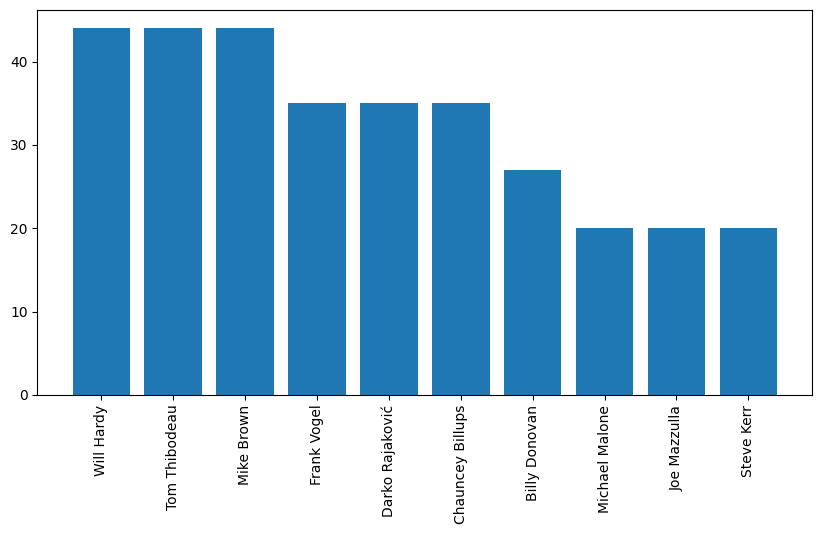

In [153]:
best_coaches = np.array(ten_best_coaches())
names = [c[0] for c in best_coaches]
exp = [c[1].astype(int) for c in best_coaches]
plt.figure(figsize=(10, 5))
plt.bar(names, exp)
plt.xticks(names, rotation='vertical')


## Посмотреть расписание игр на ближайшее время 

In [150]:
week_schedule = np.array(this_week_games())
from calendar_view.calendar import Calendar
from calendar_view.core import data
from calendar_view.core.event import Event

config = data.CalendarConfig(
    lang='en',
    title='Basketball games this week',
    dates='2024-05-10 - 2024-05-20',
    show_year=True,
    mode='working_hours',
    legend=False,
)
events = [
    Event(title=f'{g[1]}-{g[2]}', day=g[3], start=f'{(20 + g[0] + (g[0]*g[0]) % 3 + 8)%24}:00', end=f'{(20 + g[0] + (g[0]*g[0]) % 3 + 8)%24 + 2}:00') for g in week_schedule
]

data.validate_config(config)
data.validate_events(events, config)

calendar = Calendar.build(config)
calendar.add_events(events)
calendar.save("analytics_outputs/schedule.png")

## Или расписание для команд из определенного города стадиона

In [172]:
la_games = pd.DataFrame(la_stadium_schedule())
la_games

,0,1,2
0,2024-01-01,LAL,BOS
1,2024-01-05,BOS,LAL
2,2024-01-10,GSW,LAC
3,2024-01-15,LAC,GSW
4,2024-05-13,GSW,LAL
5,2024-05-25,LAL,HOU
6,2024-05-30,HOU,LAL
7,2024-06-25,MIA,LAC
8,2024-06-30,LAC,MIA
9,2024-10-15,LAL,HOU


## Посмотреть на траты комманд на зарплаты игроков и проверить не превышает ли кто потолок зарплат (эти комманды будут платить штраф лиге)

(['DEN',
  'HOU',
  'NOP',
  'LAL',
  'TOR',
  'GSW',
  'ATL',
  'SAC',
  'CHA',
  'IND',
  'BOS',
  'LAC',
  'CLE',
  'POR',
  'DAL',
  'MIL',
  'WAS',
  'SAS',
  'OKC',
  'MIN',
  'MEM',
  'PHI',
  'DET',
  'CHI',
  'BKN',
  'PHX',
  'NYK',
  'ORL',
  'MIA',
  'UTA'],
 [66900000,
  73400000,
  69200000,
  74000000,
  63800000,
  63800000,
  65900000,
  66000000,
  71300000,
  66200000,
  35500000,
  100100000,
  68200000,
  66200000,
  95700000,
  99900000,
  64600000,
  64700000,
  62600000,
  69300000,
  65700000,
  109500000,
  72400000,
  72500000,
  100800000,
  33600000,
  37200000,
  69200000,
  38300000,
  38100000])

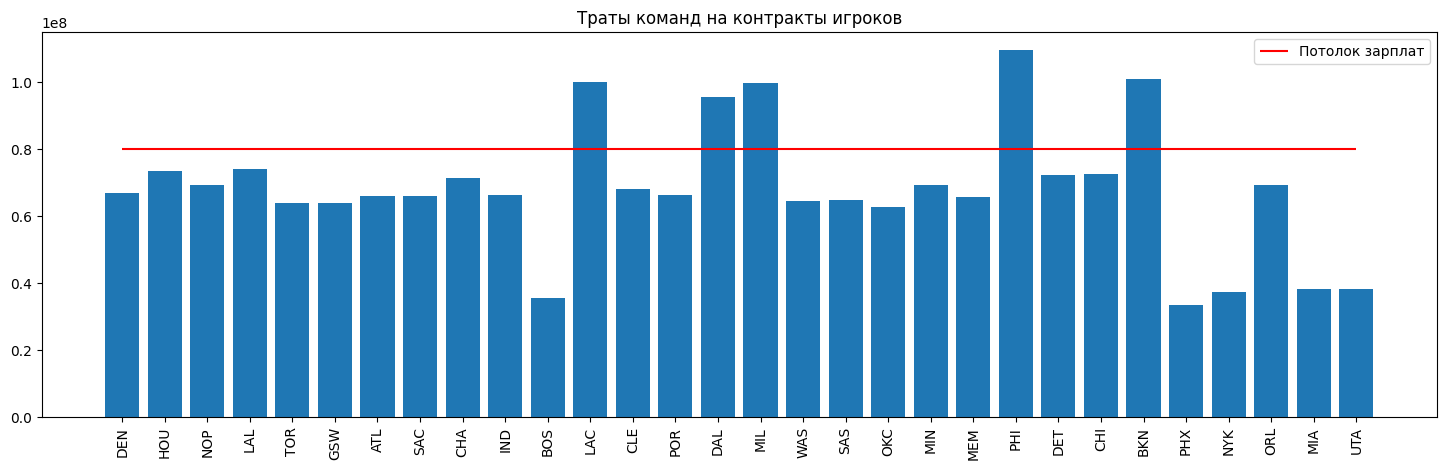

In [168]:
spendings = np.array(teams_spendings())
teams = [c[0] for c in spendings]
amounts = [c[1].astype(int) for c in spendings]
plt.figure(figsize=(18, 5))
plt.bar(teams, amounts)
plt.hlines(0.8*100000000, 'DEN', 'UTA', color='r', label = "Потолок зарплат")
plt.legend()
plt.title("Траты команд на контракты игроков")
plt.xticks(teams, rotation='vertical')
teams, amounts

## Можно посмотреть на результаты регулярного чемпионата и узнать лучшую комманду

([<matplotlib.axis.XTick at 0x1959fd375d0>,
 [Text(0.0, 0, 'Houston Rockets'),
  Text(1.0, 0, 'New York Knicks'),
  Text(2.0, 0, 'Philadelphia 76ers'),
  Text(3.0, 0, 'Boston Celtics'),
  Text(4.0, 0, 'LA Clippers'),
  Text(5.0, 0, 'Los Angeles Lakers'),
  Text(6.0, 0, 'Phoenix Suns'),
  Text(7.0, 0, 'Sacramento Kings'),
  Text(8.0, 0, 'Atlanta Hawks'),
  Text(9.0, 0, 'Miami Heat'),
  Text(10.0, 0, 'Orlando Magic'),
  Text(11.0, 0, 'Dallas Mavericks'),
  Text(12.0, 0, 'Memphis Grizzlies'),
  Text(13.0, 0, 'Detroit Pistons'),
  Text(14.0, 0, 'Indiana Pacers'),
  Text(15.0, 0, 'Denver Nuggets'),
  Text(16.0, 0, 'Minnesota Timberwolves'),
  Text(17.0, 0, 'Oklahoma City Thunder'),
  Text(18.0, 0, 'Portland Trail Blazers'),
  Text(19.0, 0, 'Utah Jazz'),
  Text(20.0, 0, 'Golden State Warriors'),
  Text(21.0, 0, 'Toronto Raptors'),
  Text(22.0, 0, 'Milwaukee Bucks'),
  Text(23.0, 0, 'New Orleans Pelicans'),
  Text(24.0, 0, 'Charlotte Hornets'),
  Text(25.0, 0, 'Cleveland Cavaliers'),
  Text(2

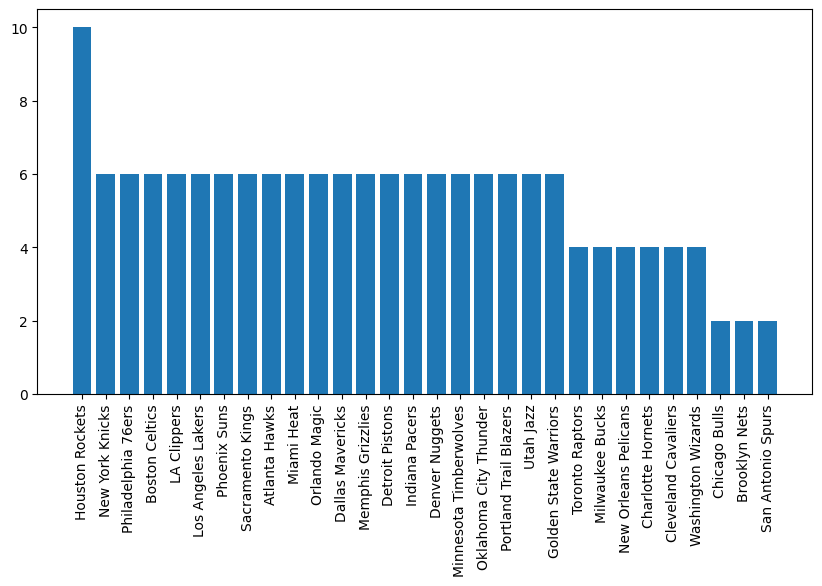

In [174]:
best_coaches = np.array(teams_and_won_matches())
teams = [c[0] for c in best_coaches]
matches = [c[1].astype(int) for c in best_coaches]
plt.figure(figsize=(10, 5))
plt.bar(teams, matches)
plt.xticks(teams, rotation='vertical')

### Лучшая команда регулярного сезона - Houston Rockets